# **1. Perkenalan Dataset**


In [1]:
# Mengunduh file dari URL kaggle
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 73.9MB/s]


In [2]:
import zipfile
import os

# Nama file yang akan diekstrak dan nama file baru
file_to_extract = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
new_file_name = "telco_clustering.csv"
zip_file_name = "telco-customer-churn.zip"

# Mengekstrak dan mengganti nama file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extract(file_to_extract)

# Mengganti nama file
if os.path.exists(file_to_extract):
    os.rename(file_to_extract, new_file_name)
    print(f"File {file_to_extract} berhasil diekstrak dan diganti nama menjadi {new_file_name}.")
else:
    print(f"File {file_to_extract} tidak ditemukan.")

File WA_Fn-UseC_-Telco-Customer-Churn.csv berhasil diekstrak dan diganti nama menjadi telco_clustering.csv.


# **2. Import Library**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# **3. Memuat Dataset**

In [4]:
telco_df = pd.read_csv("/content/telco_clustering.csv")
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **4. Exploratory Data Analysis (EDA)**

## **a. Memahami Struktur Data**

In [5]:
# Menampilkan jumlah baris dan kolom
print("Jumlah baris dan kolom:")
print(telco_df.shape)

Jumlah baris dan kolom:
(7043, 21)


In [6]:
# Menampilkan tipe data dari setiap kolom
print("\nJenis data di setiap kolom:")
telco_df.dtypes


Jenis data di setiap kolom:


,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


## **b. Menangani Data Hilang & Duplikat**

In [7]:
# Check missing value
print("\nJumlah data yang hilang di setiap kolom:")
print(telco_df.isnull().sum())


Jumlah data yang hilang di setiap kolom:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [8]:
# Check data duplikat
print("\nJumlah data duplikat:")
telco_df.duplicated().sum()


Jumlah data duplikat:


0

## **c. Analisis Distribusi dan Korelasi**

In [9]:
# Statistik deskriptif untuk variabel numerik
numerical_cols = telco_df.select_dtypes(include=np.number).columns
print("\nStatistik deskriptif untuk variabel numerik:")
telco_df[numerical_cols].describe()


Statistik deskriptif untuk variabel numerik:


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


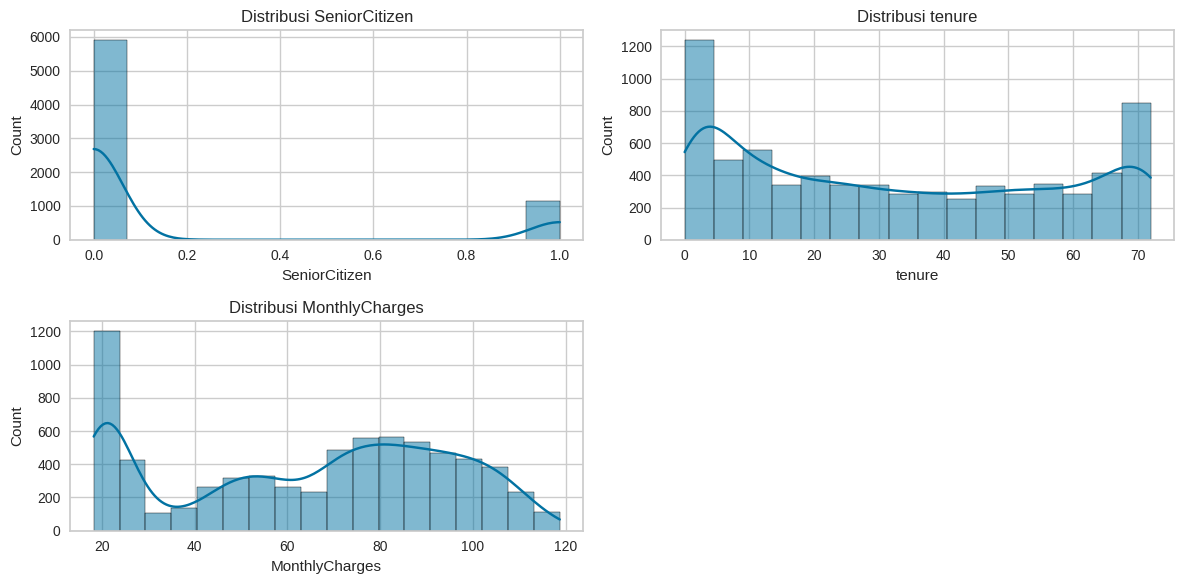

In [10]:
# Histogram untuk distribusi variabel numerik
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(telco_df[col], kde=True)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

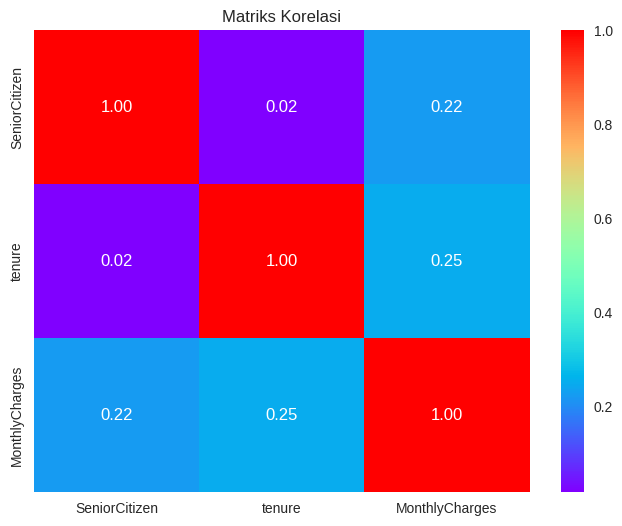

In [11]:
# Heatmap untuk hubungan antar variabel
correlation_matrix = telco_df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='rainbow', fmt=".2f")
plt.title('Matriks Korelasi')
plt.show()


## **d. Visualisasi Data**

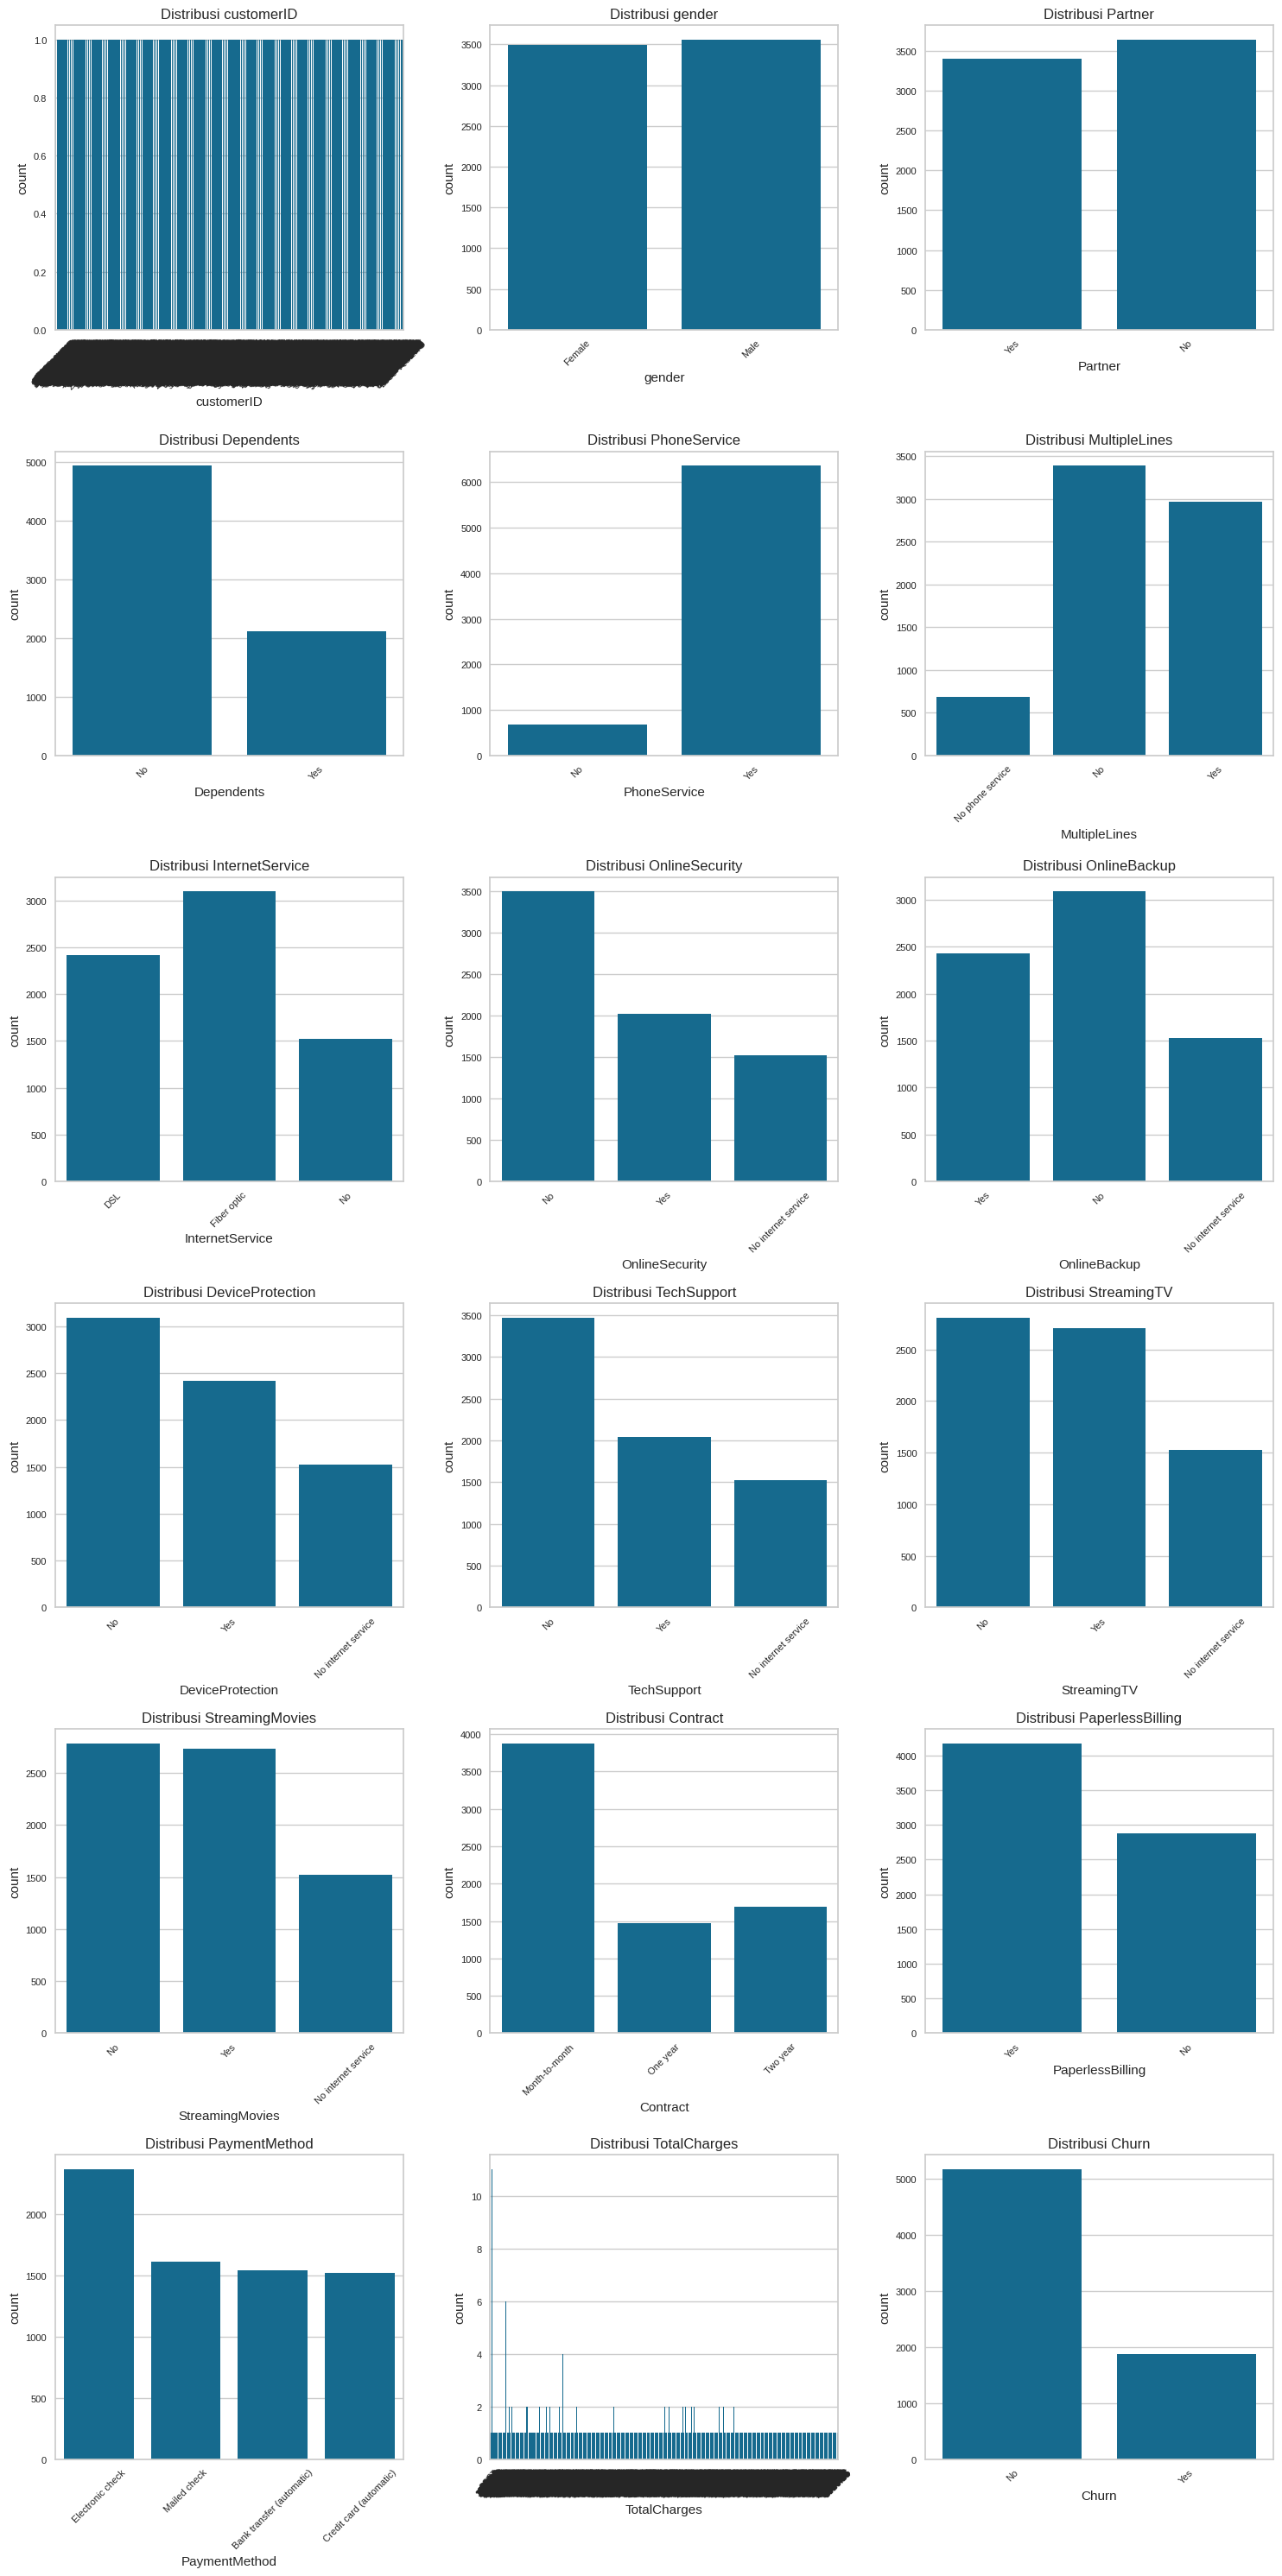

In [12]:
# Visualisasi variabel kategorikal dengan diagram batang
categorical_cols = telco_df.select_dtypes(include=['object']).columns
num_plots = len(categorical_cols)
num_rows = 6
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))

for i, col in enumerate(categorical_cols):
    row = i // num_cols
    col_idx = i % num_cols
    sns.countplot(x=col, data=telco_df, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribusi {col}')
    axes[row, col_idx].tick_params(axis='x', rotation=45, labelsize=8)
    axes[row, col_idx].tick_params(axis='y', labelsize=8)

# Hide any unused subplots
for i in range(num_plots, num_rows * num_cols):
    row = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row, col_idx])

plt.tight_layout()
plt.show()

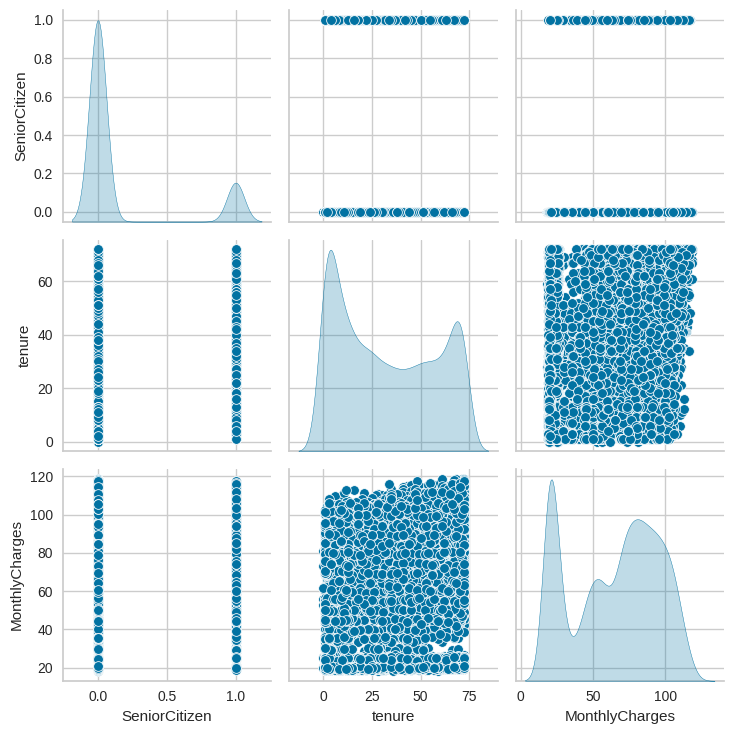

In [13]:
# Pairplot untuk analisis antar korelasi
sns.pairplot(telco_df[numerical_cols], diag_kind='kde')
plt.tight_layout()
plt.show()

# **5. Data Preprocessing**

In [14]:
# Ubah tipe data
telco_df["MonthlyCharges"] = telco_df["MonthlyCharges"].round().astype(int)
telco_df["TotalCharges"] = pd.to_numeric(telco_df["TotalCharges"].str.replace(' ', '0'), errors='coerce').fillna(0).astype(int)

In [15]:
# Mapping kolom 'SeniorCitizen'
telco_df['SeniorCitizen'] = telco_df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [16]:
# Drop kolom ID Customer dan Churn
telco_df.drop(['customerID', 'Churn'], axis=1, inplace=True)

In [17]:
# Inisialisasi StandardScaler
scaler = MinMaxScaler()
numerical_cols = telco_df.select_dtypes(include=np.number).columns

# Normalisasi data numerik
scaled_data = scaler.fit_transform(telco_df[numerical_cols])

In [18]:
# Deteksi dan Penanganan Outlier (Menggunakan IQR)
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

for col in numerical_cols:
    outliers = detect_outliers_iqr(telco_df[col])
    telco_df.loc[outliers.index, col] = telco_df[col].median()

In [19]:
# Encoding Data Kategorikal (Label Encoding)
label_encoder = LabelEncoder()
categorical_cols = telco_df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    telco_df[col] = label_encoder.fit_transform(telco_df[col])

In [20]:
# Binning (Pengelompokan Data)
telco_df['tenure'] = pd.cut(telco_df['tenure'], bins=6, labels=False)
telco_df['MonthlyCharges'] = pd.cut(telco_df['MonthlyCharges'], bins=6, labels=False)

# Menampilkan data setelah preprocessing
telco_df.sample(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
222,1,0,1,1,0,1,0,2,1,1,1,1,1,1,1,1,2,0,20
6416,1,0,0,0,5,0,1,0,2,0,0,2,2,0,2,0,2,1,3097
1698,1,0,1,1,5,1,2,1,0,2,0,2,0,0,2,1,2,3,6152
6101,0,1,0,0,5,1,2,1,2,0,2,2,2,2,2,0,1,5,7467
2200,0,0,0,0,1,1,0,0,0,2,0,0,2,0,1,0,2,2,1045
5016,0,0,0,0,0,1,0,2,1,1,1,1,1,1,0,0,1,0,108
6747,0,0,1,0,4,0,1,0,2,0,2,0,0,0,1,0,3,1,1958
4116,0,0,1,1,1,1,0,2,1,1,1,1,1,1,1,0,0,0,395
2649,0,0,1,0,5,1,2,2,1,1,1,1,1,1,2,0,1,0,1584
1909,1,0,1,1,0,1,0,2,1,1,1,1,1,1,1,0,3,0,150


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

In [21]:
# Menggunakan algoritma KMeans
kmeans = KMeans()

# Latih model dengan data
kmeans.fit(telco_df)

# Mendapatkan label CustomerType untuk setiap data point
labels = kmeans.labels_

# Manambahkan kolom 'CustomerType'
telco_df['CustomerType'] = labels

# Menampilkan beberapa baris data dengan label CustomerType
display(telco_df.sample(10))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CustomerType
5322,0,0,1,0,2,1,0,0,0,2,2,2,2,2,0,0,0,3,2078,3
4605,1,0,1,0,5,1,2,0,0,2,0,2,0,2,2,0,3,2,4234,2
4082,1,0,1,0,4,1,2,0,2,0,2,2,2,2,1,0,2,3,4059,2
1241,1,0,0,0,2,1,2,0,2,0,0,0,0,2,0,1,3,2,1888,3
6735,0,0,1,1,5,1,0,0,2,2,2,2,2,2,2,0,1,4,6328,0
1375,0,0,1,1,3,1,0,2,1,1,1,1,1,1,2,1,0,0,854,1
3581,1,0,1,1,5,1,0,0,2,2,2,2,2,0,2,0,1,3,4674,6
553,0,0,1,1,1,1,2,2,1,1,1,1,1,1,2,1,1,0,514,5
6534,0,1,0,0,4,1,0,1,2,2,0,2,0,2,1,1,3,4,5206,6
5046,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,45,5


## **b. Evaluasi Model Clustering**

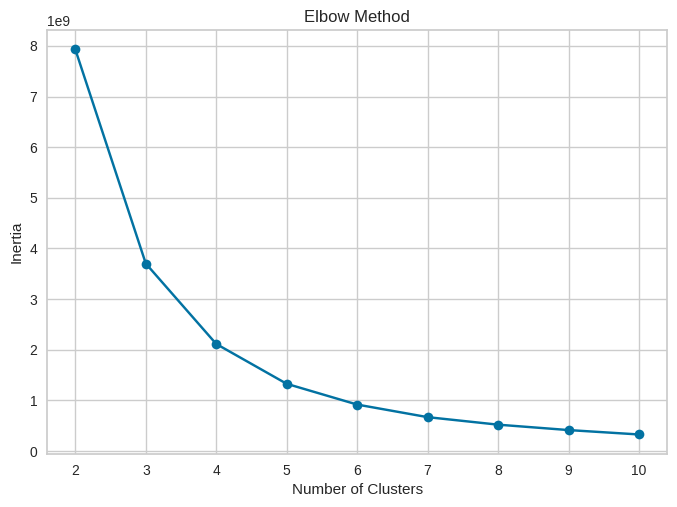

In [22]:
# Inertia (Elbow Method)
inertia = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(telco_df)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [23]:
best_n_clusters_elbow = 3
print(f"Jumlah cluster optimal dengan Elbow method adalah: {best_n_clusters_elbow} cluster")

Jumlah cluster optimal dengan Elbow method adalah: 3 cluster


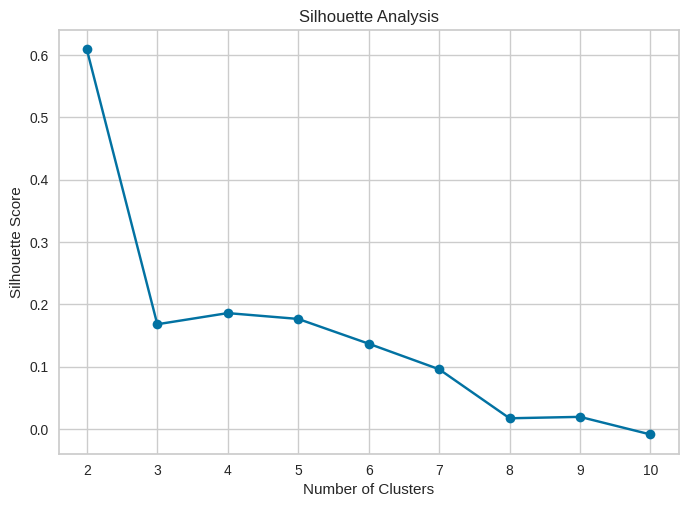

In [24]:
# Silhouette Analysis
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(telco_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Analysis
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [25]:
best_n_clusters_silhouette = 2
print(f"Jumlah cluster optimal dengan Silhouette method adalah: {best_n_clusters_silhouette} cluster")

Jumlah cluster optimal dengan Silhouette method adalah: 2 cluster


In [26]:
# Hitung silhouette score (n_clusters = 2)
kmeans_2 = KMeans(n_clusters=2, random_state=42)
kmeans_2.fit(telco_df)
labels_2 = kmeans_2.labels_
silhouette_2 = silhouette_score(telco_df, labels_2)
print(f"Silhouette score for n_clusters=2: {silhouette_2}")

# Hitung silhouette score (n_clusters = 3)
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(telco_df)
labels_3 = kmeans_3.labels_
silhouette_3 = silhouette_score(telco_df, labels_3)
print(f"Silhouette score for n_clusters=3: {silhouette_3}")

Silhouette score for n_clusters=2: 0.7035991250342198
Silhouette score for n_clusters=3: 0.6457455567392245


In [27]:
if silhouette_2 > silhouette_3:
    print(f"Silhouette score tertinggi: {silhouette_2} (n_clusters=2)")
else:
    print(f"Silhouette score tertinggi: {silhouette_3} (n_clusters=3)")

Silhouette score tertinggi: 0.7035991250342198 (n_clusters=2)


## **c. Feature Selection (Opsional)**

In [28]:
correlation_matrix = telco_df.corr()
correlation_matrix

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CustomerType
gender,1.000000,-0.001874,-0.001808,0.010517,0.005812,-0.006488,-0.006739,-0.000863,-0.015017,-0.012057,0.000549,-0.006825,-0.006421,-0.008743,0.000126,-0.011754,0.017352,-0.012606,-0.000079,0.015112
SeniorCitizen,-0.001874,1.000000,0.016479,-0.211185,0.016776,0.008576,0.146185,-0.032310,-0.128221,-0.013632,-0.021398,-0.151268,0.030776,0.047266,-0.142554,0.156530,-0.038551,0.218742,0.103008,0.014539
Partner,-0.001808,0.016479,1.000000,0.452676,0.367999,0.017706,0.142410,0.000891,0.150828,0.153130,0.166330,0.126733,0.137341,0.129574,0.294806,-0.014877,-0.154798,0.096517,0.317503,-0.108865
Dependents,0.010517,-0.211185,0.452676,1.000000,0.154343,-0.001762,-0.024991,0.044590,0.152166,0.091015,0.080537,0.133524,0.046885,0.021321,0.243187,-0.111377,-0.040292,-0.109356,0.062078,-0.049509
tenure,0.005812,0.016776,0.367999,0.154343,1.000000,0.007985,0.334694,-0.029683,0.314980,0.365346,0.360966,0.314282,0.281748,0.288787,0.658207,0.004805,-0.360531,0.243395,0.817455,-0.233615
PhoneService,-0.006488,0.008576,0.017706,-0.001762,0.007985,1.000000,-0.020538,0.387436,-0.015198,0.024105,0.003727,-0.019158,0.055353,0.043870,0.002247,0.016505,-0.004184,0.270611,0.113213,-0.059671
MultipleLines,-0.006739,0.146185,0.142410,-0.024991,0.334694,-0.020538,1.000000,-0.109216,0.007141,0.117327,0.122318,0.011466,0.175059,0.180957,0.110842,0.165146,-0.176793,0.413535,0.452576,-0.103351
InternetService,-0.000863,-0.032310,0.000891,0.044590,-0.029683,0.387436,-0.109216,1.000000,-0.028416,0.036138,0.044944,-0.026047,0.107417,0.098350,0.099721,-0.138625,0.086140,-0.274719,-0.175756,-0.053816
OnlineSecurity,-0.015017,-0.128221,0.150828,0.152166,0.314980,-0.015198,0.007141,-0.028416,1.000000,0.185126,0.175985,0.285028,0.044669,0.055954,0.374416,-0.157641,-0.096726,-0.052121,0.253223,-0.070289
OnlineBackup,-0.012057,-0.013632,0.153130,0.091015,0.365346,0.024105,0.117327,0.036138,0.185126,1.000000,0.187757,0.195748,0.147186,0.136722,0.280980,-0.013370,-0.124847,0.127517,0.374410,-0.073888


In [29]:
correlations_with_customertype = correlation_matrix['CustomerType'].abs().sort_values(ascending=False)
top_features = correlations_with_customertype[1:6].index
print("Top Features:")
top_features

Top Features:


Index(['tenure', 'Contract', 'TotalCharges', 'Partner', 'MultipleLines'], dtype='object')

In [30]:
# Mengambil fitur teratas berdasarkan korelasi
selected_telco_df = telco_df[top_features.tolist()]

# Menampilkan sampel data
print("Data setelah feature selection:")
display(selected_telco_df.sample(10))

Data setelah feature selection:


,tenure,Contract,TotalCharges,Partner,MultipleLines
5605,0,0,563,1,0
7039,5,1,7362,1,2
158,1,2,1024,1,0
4450,1,0,939,0,2
2748,0,0,174,0,1
4977,1,1,469,1,0
656,5,2,6132,1,2
3962,0,0,646,1,2
6267,0,0,70,0,0
2483,3,0,4541,1,2


In [31]:
# Hitung silhouette score setelah feature selection (n_clusters = 2)
kmeans_selected = KMeans(n_clusters=2, random_state=42)
kmeans_selected.fit(selected_telco_df)
labels_selected = kmeans_selected.labels_
silhouette_selected = silhouette_score(selected_telco_df, labels_selected)
print(f"Silhouette score for n_clusters=2 after feature selection: {silhouette_selected}")

Silhouette score for n_clusters=2 after feature selection: 0.7036259143277088


## **d. Visualisasi Hasil Clustering**

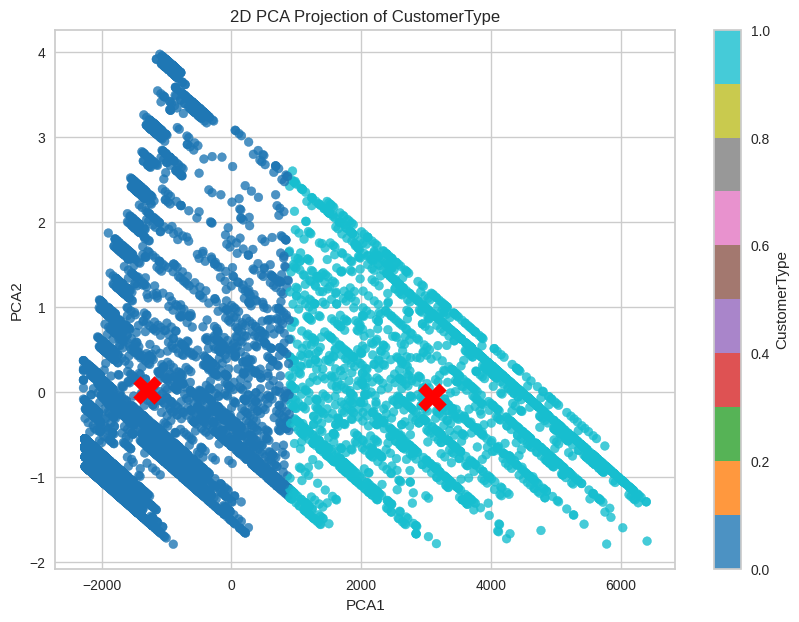

In [32]:
# Menjalankan clustering KMeans dengan 2 cluster
kmeans = KMeans(n_clusters=2, random_state=42)
selected_telco_df['CustomerType'] = kmeans.fit_predict(selected_telco_df[top_features])

# Reduksi dimensi menggunakan PCA ke 2 komponen
pca = PCA(n_components=2)
pca_result = pca.fit_transform(selected_telco_df[top_features])
selected_telco_df['PCA1'] = pca_result[:, 0]
selected_telco_df['PCA2'] = pca_result[:, 1]

# Menyimpan koordinat pusat cluster dalam PCA
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# Visualisasi 2D PCA Projection
plt.figure(figsize=(10, 7))
scatter = plt.scatter(selected_telco_df['PCA1'], selected_telco_df['PCA2'],
                      c=selected_telco_df['CustomerType'], cmap='tab10', s=40, alpha=0.8)

# Menambahkan titik centroid
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            c='red', marker='X', s=400, label='Centroids')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('2D PCA Projection of CustomerType')
plt.colorbar(scatter, label='CustomerType')
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

In [33]:
# Analisis karakteristik tiap cluster
for cluster_label in range(2):
    cluster_data = selected_telco_df[selected_telco_df['CustomerType'] == cluster_label]
    print(f"\nKarakteristik CustomerType {cluster_label}:")

    # Menghitung deskripsi statistik dan menyimpannya dalam DataFrame
    stats = pd.DataFrame()
    for feature in top_features:
        stats[feature] = cluster_data[feature].describe()

    display(stats)


Karakteristik CustomerType 0:


,tenure,Contract,TotalCharges,Partner,MultipleLines
count,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000
mean,1.292550,0.486776,978.164547,0.398344,0.706844
std,1.530987,0.753745,869.991672,0.489607,0.892024
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,217.000000,0.000000,0.000000
50%,1.000000,0.000000,745.000000,0.000000,0.000000
75%,2.000000,1.000000,1533.000000,1.000000,2.000000
max,5.000000,2.000000,3171.000000,1.000000,2.000000



Karakteristik CustomerType 1:


,tenure,Contract,TotalCharges,Partner,MultipleLines
count,2090.000000,2090.000000,2090.000000,2090.000000,2090.000000
mean,4.275120,1.173206,5362.686603,0.683732,1.494258
std,0.879751,0.815509,1414.670461,0.465130,0.842967
min,2.000000,0.000000,3173.000000,0.000000,0.000000
25%,4.000000,0.000000,4138.000000,0.000000,1.000000
50%,5.000000,1.000000,5224.000000,1.000000,2.000000
75%,5.000000,2.000000,6424.750000,1.000000,2.000000
max,5.000000,2.000000,8684.000000,1.000000,2.000000


**CustomerType 0**

1.    *Tenure*:

    •    Rata-rata: 1.29 bulan

    •    Distribusi: 25% di cluster ini adalah pelanggan baru (0 bulan), dan sebagian besar pelanggan lainnya memiliki tenure antara 1 dan 2 bulan.

    •    Interpretasi: Mayoritas pelanggan adalah pelanggan baru, yang menunjukkan bahwa perusahaan perlu fokus pada retensi dan pengalaman pelanggan untuk segmen ini.

2.    *Contract*:

    •    Rata-rata: 0.49

    •    Distribusi: 75% pelanggan memiliki kontrak bulanan dan 25% pelanggan memiliki kontrak 1 tahun.

    •    Interpretasi: Pelanggan di cluster ini cenderung masih dalam tahap evaluasi layanan, sehingga mereka memilih kontrak yang lebih pendek, sehingga lebih fleksibel untuk mengubah layanan pada setelah kontrak berakhir.    
    
3.    *TotalCharges*:

    •    Rata-rata: 978.16

    •    Distribusi: 25% pelanggan memiliki total charges di bawah 217, median 745, dan maksimum 3171.

    •    Interpretasi: Pelanggan di cluster ini mengeluarkan biaya yang lebih rendah, mungkin karena memilih paket dasar atau tidak menggunakan banyak layanan tambahan.

4.    *Partner*:

    •    Rata-rata: 0.40

    •    Distribusi: 75% pelanggan berada pada kategori tidak memiliki partner, dan 25% pada kategori memiliki partner.

    •    Interpretasi: Pelanggan di Cluster ini cenderung tidak memiliki partner. Hal ini mungkin mengindikasikan bahwa mereka adalah individu yang lebih muda atau single.

5.    *MultipleLines*:

    •    Rata-rata: 0.71

    •    Distribusi: 25% tidak memiliki multiple lines, 50% memiliki 1, dan 25% memiliki 2.

    •    Interpretasi: Cluster ini menunjukkan bahwa sebagian besar pelanggan tidak memiliki layanan multiple lines. Hal ini menunjukkan ketergantungan yang lebih rendah terhadap layanan telekomunikasi tambahan.


**CustomerType 1**

1.    *Tenure*:

    •    Rata-rata: 4.27 bulan

    •    Distribusi: Pelanggan di cluster ini memiliki tenure minimum 2 bulan, dan sebagian besar pelanggan memiliki tenure antara 4 dan 5 bulan.

    •    Interpretasi: Pelanggan di cluster ini cenderung lebih setia, yang berarti perusahaan dapat memanfaatkan loyalitas ini untuk meningkatkan penawaran atau upselling.

2.    *Contract*:

    •    Rata-rata: 1.17

    •    Distribusi: Distribusi menunjukkan: 25% pelanggan memiliki kontrak bulanan, 50% pelanggan memiliki kontrak 1 tahunan dan 25% pelanggan memiliki kontrak 2 tahunan.

    •    Interpretasi: Pelanggan di cluster ini merasa puas terhadap layanan sehingga cenderung lebih loyal dan berkomitmen untuk menggunakan layanan dalam jangka waktu lebih lama.

3.    *Total Charges*:

    •    Rata-rata: 5362.69

    •    Distribusi: Minimum 3173, dengan median 5224 dan maksimum 8684.

    •    Interpretasi: Pelanggan di cluster ini menghabiskan lebih banyak, menunjukkan penggunaan yang lebih tinggi dari layanan premium. Ini bisa menjadi target untuk cross-selling produk premium atau tambahan.


4.   *Partner*:

    •    Rata-rata: 0.68

    •    Distribusi: 25% pelanggan berada pada kategori tidak memiliki partner dan 75% pada kategori memiliki partner.

    •    Interpretasi: Pelanggan di cluster ini cenderung memiliki partner. Hal ini mungkin mengindikasikan bahwa mereka adalah keluarga atau pasangan.


5.    *MultipleLines*:

    •    Rata-rata: 1.49

    •    Distribusi: 25% pelanggan memiliki 1 multiple line, median 2.

    •    Interpretasi: Pelanggan di cluster ini lebih cenderung menggunakan layanan multiple lines, menunjukkan kebutuhan untuk komunikasi lebih dari satu jalur atau keinginan untuk mengoptimalkan biaya.


# **7. Mengeksport Data**

In [34]:
# Save the results to a CSV file
telco_df.to_csv('telco_cluster_label.csv', index=False)

from google.colab import files
files.download('telco_cluster_label.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>